In [1]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

ENCODER = "resnet34"
PRETRAINED_WEIGHT = "imagenet"
CLASSES = [
    "void", "road", "sidewalk", "building", "wall", "fence", "pole", "traffic light", 
    "traffic sign", "vegetation", "terrain", "sky", "person", "rider", "car", "truck", 
    "bus", "train", "motorcycle", "bicycle", "road lines", "other", "road works"
]
#CLASSES = ["void", "car", "person"]

model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=PRETRAINED_WEIGHT,
    in_channels=3,
    classes=len(CLASSES)
)

preprocess_input = get_preprocessing_fn(ENCODER, pretrained=PRETRAINED_WEIGHT)

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

plt.rcParams["figure.figsize"] = (20,10)

### Loading data

We use `SYNTHIA-SF` dataset.
Load and prepare dataset

In [4]:
DATA_DIR = "../../Dataset/SYNTHIA-SF"
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    print('Done!')
else:
    print("SYNTHIA-SF data dir already exist!")

SYNTHIA-SF data dir already exist!


In [5]:
import glob
from PIL import Image
from pathlib import Path
from torch.utils.data import Dataset, DataLoader

class SynthiaDataset(Dataset):
    CLASSES = [
        "void", "road", "sidewalk", "building", "wall", "fence", "pole", "traffic light", 
        "traffic sign", "vegetation", "terrain", "sky", "person", "rider", "car", "truck", 
        "bus", "train", "motorcycle", "bicycle", "road lines", "other", "road works"
    ]

    def __init__(self, path="../../Dataset/SYNTHIA-SF", classes=None, augmentation=None, preprocessing=None, albutrans=False):
        """Constructor"""
        super().__init__()
        # get list of file
        self.left_imgs, self.left_gts = self.prepare_data(path) 
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.albutrans = albutrans
    
    def __getitem__(self, index):
        """Get sample"""
        # read data
        image = Image.open(self.left_imgs[index]).convert("RGB") # convert from 4 channel to 3 channel
        mask = Image.open(self.left_gts[index]).convert("RGB").getchannel("R") # RED channel specify label ID

        # extract certain classes from mask (e.g. cars)
        mask_array = np.array(mask)
        masks = [(mask_array == v) for v in self.class_values]
        #print(masks)
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            if self.albutrans:
                # Convert PIL image to numpy array
                image_np = np.array(image)
                mask_np = np.array(mask)
                # Apply transformations
                sample = self.augmentation(image=image_np, mask=mask_np)
                # Convert numpy array to PIL Image
                image, mask = Image.fromarray(sample['image']), Image.fromarray(sample['mask'])
            else:
                # Using torchvision transform
                sample = self.augmentation(image=image, mask=mask)
                image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask

    def __len__(self) -> int:
        """Return dataset size"""
        return len(self.right_imgs)

    @classmethod
    def prepare_data(self, path):
        rootdir = Path(path)
        """Return list of all images in dataset"""
        left_imgs = list(rootdir.glob("*/RGBLeft/*.png"))
        left_gts = list(rootdir.glob("*/GTLeft/*.png"))
        return left_imgs, left_gts

[14, 12]
(1080, 1920, 2)


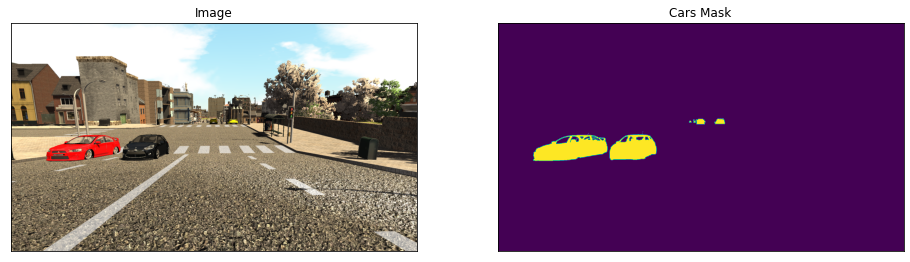

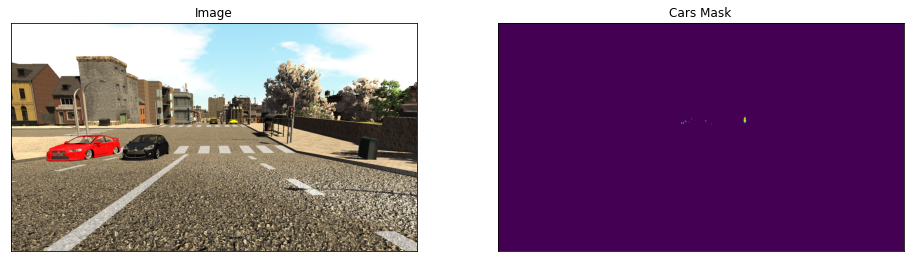

In [17]:
# Lets look at data we have
dataset = SynthiaDataset(classes=["car", "person"])

image, mask = dataset[0] # get some sample
print(dataset.class_values)
print(mask.shape)
visualize(image=image, cars_mask=mask[...,0],) # car GT
visualize(image=image, cars_mask=mask[...,1],) # person GT

### Data Augmentation

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.
Since our dataset is very small we will apply a large number of different augmentations:

horizontal flip
affine transforms
perspective transforms
brightness/contrast/colors manipulations
image bluring and sharpening
gaussian noise
random crops

All this transforms can be easily applied with Albumentations - fast augmentation library. For detailed explanation of image transformations you can look at kaggle salt segmentation exmaple provided by Albumentations authors.

from: https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb
(WARNING: based on OpenCV)

In [7]:
import albumentations as albu

In [8]:
# WARNING >> Based on OpenCV 
def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [9]:
augmented_dataset = SynthiaDataset(
    augmentation=get_training_augmentation(),
    classes=["car"]
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))

D:\anaconda3\envs\mmcv\lib\site-packages\albumentations\imgaug\transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
D:\anaconda3\envs\mmcv\lib\site-packages\albumentations\imgaug\transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
D:\anaconda3\envs\mmcv\lib\site-packages\albumentations\augmentations\transforms.py:1746: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
D:\anaconda3\envs\mmcv\lib\site-packages\albumentations\imgaug\transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
D:\anaconda3\envs\mmcv\lib\site-package

TypeError: image must be numpy array type

#### Test script goes here

In [ ]:
import glob
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch, torchvision

DATA_DIR = "../../Dataset/SYNTHIA-SF"
rootdir = Path(DATA_DIR)
images = list(rootdir.glob("*/RGBLeft/*.png"))
masks = list(rootdir.glob("*/GTLeft/*.png"))
print(len(images))
print(len(masks))
plt.rcParams["figure.figsize"] = (20,10)

In [ ]:
trf = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
])

index = 0
img_path = images[index]
msk_path = masks[index]

img = Image.open(img_path).convert("RGB")
msk = Image.open(msk_path).convert("RGB")

print(img)
plt.imshow(msk)

In [ ]:
msk_array = np.array(msk)
print(msk_array.shape)
plt.figure()
plt.imshow(msk_array[...,0])
plt.figure()
plt.imshow(msk_array[...,1])
plt.figure()
plt.imshow(msk_array[...,2])

In [ ]:
masks = [(msk_array[...,0] == 14)]
#masks_bin = np.stack(masks, axis=-1).astype('float')
print(masks)

In [ ]:
def getIDs(path):
    # read image
    img = Image.open(path).convert("RGB") # convert to RGB
    # convert as int32 array
    img = np.array(img, dtype=int)

    label_matrix = img[...,0]
    instance_matrix = img[...,2] + img[...,1]*256

    return label_matrix, instance_matrix

label, instance = getIDs(msk_path)
plt.imshow(label)
plt.figure()
plt.imshow(instance)

